# ANALISIS SENTIMEN TIKTOK SHOP MENGGUNAKAN METODE SVM PSO

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import time
from imblearn.over_sampling import SMOTE

# PREPROCESSING

In [2]:
dataset_path ='data_ttshop_FIX.csv'
df = pd.read_csv(dataset_path)
df.head(10)

,Tweet,Sentimen,Label
0,tolong tiktokshop jangan ditutup dulu sampe ak...,Netral,1
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...",Positif,2
2,Anj lahh tiktok shop mau ditutup mana itu rese...,Positif,2
3,sbg yg sering beli barang via tiktokshop drpd ...,Positif,2
4,TikTok Shop ditutup gak bikin orang berbondong...,Positif,2
5,Inilah kekuatan negara Cina berdagang yang mam...,Positif,2
6,tiktok shop katanya mau ditutup y ðŸ˜”,Negatif,0
7,gblk dah itu tiktokshop ditutup bgst aku pake ...,Negatif,0
8,Nangis bgt tiktok shop mau ditutup.. Gabisa be...,Negatif,0
9,Udah denger berita kalo TikTok Shop mau ditutu...,Positif,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet     2562 non-null   object
 1   Sentimen  2562 non-null   object
 2   Label     2562 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 60.2+ KB


### CaseFolding

In [8]:
#Case Folding
df['CaseFolding'] = df['Tweet'].str.lower()
df

,Tweet,Sentimen,CaseFolding
0,tolong tiktokshop jangan ditutup dulu sampe ak...,Netral,tolong tiktokshop jangan ditutup dulu sampe ak...
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...",Positif,"kalau tiktok shop bener2 ditutup, tiktok ads a..."
2,Anj lahh tiktok shop mau ditutup mana itu rese...,Positif,anj lahh tiktok shop mau ditutup mana itu rese...
3,sbg yg sering beli barang via tiktokshop drpd ...,Positif,sbg yg sering beli barang via tiktokshop drpd ...
4,TikTok Shop ditutup gak bikin orang berbondong...,Positif,tiktok shop ditutup gak bikin orang berbondong...
...,...,...,...
2557,tiktok shop ada lagi anjayÃ°Å¸ËœÂ­,Netral,tiktok shop ada lagi anjayã°å¸ëœâ­
2558,Tiktokshop balik takut khilaf nanti belanja ba...,Negatif,tiktokshop balik takut khilaf nanti belanja ba...
2559,@berlianidris Lha itu Tiktok Shop Live gitu ka...,Positif,@berlianidris lha itu tiktok shop live gitu ka...
2560,Tanyarl info jadi buzzer tiktok shop dong gais,Netral,tanyarl info jadi buzzer tiktok shop dong gais


### Cleaning

In [9]:
def remove_tweet_special(text):
       
    #menghapus username twitter
    text = re.sub('@[^\s]+','',text)
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # Memperbaiki pemisahan kata yang salah menggunakan regex
    text = re.sub(r'([a-zA-Z])\-([a-zA-Z])', r'\1 \2', text)
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    #remove punctuation
    text = text.translate(str.maketrans("","",string.punctuation))
    # remove white space
    text = text.strip()
    #remove multiple white space
    text = re.sub('\s+',' ',text)
    # Mengganti "tiktokshop" menjadi "tiktok shop"
    text = re.sub(r'tiktokshop', 'tiktok shop', text, flags=re.IGNORECASE)
     # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

df['cleaned'] = df['CaseFolding'].apply(remove_tweet_special)
df_cleaned = df[["Tweet","cleaned"]]
df_cleaned

,Tweet,cleaned
0,tolong tiktokshop jangan ditutup dulu sampe ak...,tolong tiktok shop jangan ditutup dulu sampe a...
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...",kalau tiktok shop bener2 ditutup tiktok ads ak...
2,Anj lahh tiktok shop mau ditutup mana itu rese...,anj lahh tiktok shop mau ditutup mana itu rese...
3,sbg yg sering beli barang via tiktokshop drpd ...,sbg yg sering beli barang via tiktok shop drpd...
4,TikTok Shop ditutup gak bikin orang berbondong...,tiktok shop ditutup gak bikin orang berbondong...
...,...,...
2557,tiktok shop ada lagi anjayÃ°Å¸ËœÂ­,tiktok shop ada lagi anjay
2558,Tiktokshop balik takut khilaf nanti belanja ba...,tiktok shop balik takut khilaf nanti belanja b...
2559,@berlianidris Lha itu Tiktok Shop Live gitu ka...,lha itu tiktok shop live gitu kalo mau jualan ...
2560,Tanyarl info jadi buzzer tiktok shop dong gais,tanyarl info jadi buzzer tiktok shop dong gais


### Tokenizing

In [10]:
def tokenizingText(tweet):
  tweet = word_tokenize(tweet)
  return tweet
df['Tokenizing']= df['cleaned'].apply(tokenizingText)
df_tokenized = df[["Tweet","Tokenizing"]]
df_tokenized

,Tweet,Tokenizing
0,tolong tiktokshop jangan ditutup dulu sampe ak...,"[tolong, tiktok, shop, jangan, ditutup, dulu, ..."
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...","[kalau, tiktok, shop, bener2, ditutup, tiktok,..."
2,Anj lahh tiktok shop mau ditutup mana itu rese...,"[anj, lahh, tiktok, shop, mau, ditutup, mana, ..."
3,sbg yg sering beli barang via tiktokshop drpd ...,"[sbg, yg, sering, beli, barang, via, tiktok, s..."
4,TikTok Shop ditutup gak bikin orang berbondong...,"[tiktok, shop, ditutup, gak, bikin, orang, ber..."
...,...,...
2557,tiktok shop ada lagi anjayÃ°Å¸ËœÂ­,"[tiktok, shop, ada, lagi, anjay]"
2558,Tiktokshop balik takut khilaf nanti belanja ba...,"[tiktok, shop, balik, takut, khilaf, nanti, be..."
2559,@berlianidris Lha itu Tiktok Shop Live gitu ka...,"[lha, itu, tiktok, shop, live, gitu, kalo, mau..."
2560,Tanyarl info jadi buzzer tiktok shop dong gais,"[tanyarl, info, jadi, buzzer, tiktok, shop, do..."


### Normalization

In [11]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in ulasan:
        filterSlang = pattern.sub(lambda x: kamusSlang[x.group()],kata)
        content.append(filterSlang.lower())
    ulasan = content
    return ulasan
    

normalized_word = pd.read_csv("normalisasi.csv")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]


df['Formalisasi'] = df['Tokenizing'].apply(convertToSlangword)
df['Formalisasi'] = df['Formalisasi'].apply(normalized_term)

In [12]:
df_normalized = df[["Tweet","Formalisasi"]]
df_normalized

,Tweet,Formalisasi
0,tolong tiktokshop jangan ditutup dulu sampe ak...,"[tolong, tiktok, shop, jangan, ditutup, dulu, ..."
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...","[kalau, tiktok, shop, bener2, ditutup, tiktok,..."
2,Anj lahh tiktok shop mau ditutup mana itu rese...,"[anjing, lahh, tiktok, shop, mau, ditutup, man..."
3,sbg yg sering beli barang via tiktokshop drpd ...,"[sebagai, yang, sering, beli, barang, melalui,..."
4,TikTok Shop ditutup gak bikin orang berbondong...,"[tiktok, shop, ditutup, tidak, bikin, orang, b..."
...,...,...
2557,tiktok shop ada lagi anjayÃ°Å¸ËœÂ­,"[tiktok, shop, ada, lagi, anjay]"
2558,Tiktokshop balik takut khilaf nanti belanja ba...,"[tiktok, shop, balik, takut, khilaf, nanti, be..."
2559,@berlianidris Lha itu Tiktok Shop Live gitu ka...,"[lha, itu, tiktok, shop, live, begitu, kalau, ..."
2560,Tanyarl info jadi buzzer tiktok shop dong gais,"[tanyarl, informasi, jadi, buzzer, tiktok, sho..."


### Stopword Removal

In [2]:
#TIDAK DIPAKAI
#daftar_stopword = stopwords.words('indonesian')

#def stopwordText(words):
 #return [word for word in words if word not in daftar_stopword]

#df['Stopword Removal'] = df['Formalisasi'].apply(stopwordText)

In [1]:
#df_stopword = df[["Tweet","Stopword Removal"]]
#df_stopword

### Stemming

In [13]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['Formalisasi']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    
def stemmingText(document):
    return [term_dict[term] for term in document]

df['Stemming'] = df['Formalisasi'].swifter.apply(stemmingText)

Pandas Apply:   0%|          | 0/2562 [00:00<?, ?it/s]

In [14]:
df_stemming = df[["Tweet","Stemming"]]
df_stemming.head()

,Tweet,Stemming
0,tolong tiktokshop jangan ditutup dulu sampe ak...,"[tolong, tiktok, shop, jangan, tutup, dulu, sa..."
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...","[kalau, tiktok, shop, bener2, tutup, tiktok, i..."
2,Anj lahh tiktok shop mau ditutup mana itu rese...,"[anjing, lahh, tiktok, shop, mau, tutup, mana,..."
3,sbg yg sering beli barang via tiktokshop drpd ...,"[bagai, yang, sering, beli, barang, lalu, tikt..."
4,TikTok Shop ditutup gak bikin orang berbondong...,"[tiktok, shop, tutup, tidak, bikin, orang, bon..."


## Hasil Preprocessing

In [15]:
df['preprocessed'] = df['Formalisasi']
df['preprocessed'] = [' '.join(words) for words in df['preprocessed']]
df_cleaned = df[["Tweet",'preprocessed',"Sentimen"]]
df_cleaned.head()

,Tweet,preprocessed,Sentimen
0,tolong tiktokshop jangan ditutup dulu sampe ak...,tolong tiktok shop jangan ditutup dulu sampai ...,Netral
1,"kalau tiktok shop bener2 ditutup, tiktok ads a...",kalau tiktok shop bener2 ditutup tiktok iklan ...,Positif
2,Anj lahh tiktok shop mau ditutup mana itu rese...,anjing lahh tiktok shop mau ditutup mana itu r...,Positif
3,sbg yg sering beli barang via tiktokshop drpd ...,sebagai yang sering beli barang melalui tiktok...,Positif
4,TikTok Shop ditutup gak bikin orang berbondong...,tiktok shop ditutup tidak bikin orang berbondo...,Positif


In [16]:
df_cleaned.to_csv("data_ttshop_cleaned_baru.csv",index=False)
df.to_csv("data_ttshop_preprocessed_baru.csv",index=False)

# TRAINING MODEL


Jumlah Data Sentiment Positif:
1020

Jumlah Data Sentiment Negatif:
915

Jumlah Data Sentiment Netral:
627


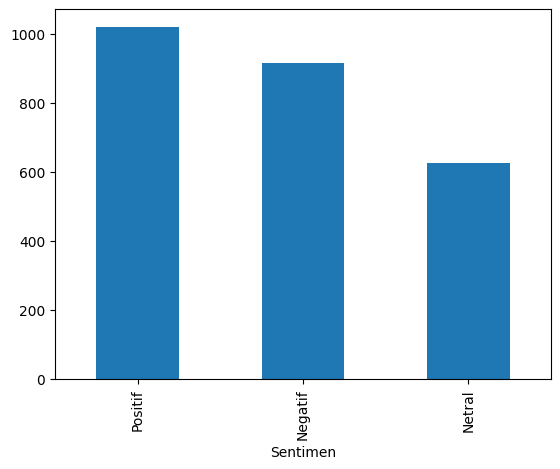

In [4]:
df= pd.read_csv("data_ttshop_cleaned_baru.csv")
print('\nJumlah Data Sentiment Positif:')
dt = df.query("Sentimen == 'Positif'")
print(len(dt))
print('\nJumlah Data Sentiment Negatif:')
dt = df.query("Sentimen == 'Negatif'")
print(len(dt))
print('\nJumlah Data Sentiment Netral:')
dt = df.query("Sentimen == 'Netral'")
print(len(dt))
df['Sentimen'].value_counts().plot(kind='bar')
plt.show()

In [5]:
df.drop(['Tweet'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   preprocessed  2562 non-null   object
 1   Sentimen      2562 non-null   object
dtypes: object(2)
memory usage: 40.2+ KB


In [7]:
 #Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Melakukan label encoding pada kolom 'sentimen'
df['Label'] = label_encoder.fit_transform(df['Sentimen'])


## Split Data & TF-IDF

In [15]:
#data utuh
X = df['preprocessed']
Y = df['Label']

print(X[0])
vectorizer = TfidfVectorizer()
X_sm = vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_sm, Y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.1,random_state=42)
print(X_train[0])

tolong tiktok shop jangan ditutup dulu sampai akhir tahun saya mau beli wishlist
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 5932)>
  Coords	Values
  (0, 5505)	0.05348388045641342
  (0, 4986)	0.05375593159635216
  (0, 2400)	0.15666241892411423
  (0, 1141)	0.11942587825500059
  (0, 5472)	0.16423137906911295
  (0, 718)	0.16875300495774667
  (0, 722)	0.4055578324226859
  (0, 5689)	0.3905040416001604
  (0, 4645)	0.3905040416001604
  (0, 3153)	0.3788274142863654
  (0, 626)	0.3788274142863654
  (0, 2333)	0.3788274142863654


## DEF FUNGSI

In [9]:
# Fungsi untuk mengubah kernel
def create_svm_model(kernel='linear', C=1.0, gamma='scale'):
    model = svm.SVC(kernel=kernel, C=C, gamma=gamma,probability=True)
    return model

# Fungsi untuk melatih model SVM
def train_svm_model(X_train, y_train, kernel='linear', C=1.0, gamma='scale'):
    model = create_svm_model(kernel, C, gamma)
    model.fit(X_train, y_train)
    print(f'Jml. Fitur\t: {X_train.shape[1]}')
    return model

# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Precision\t: {:.4}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Recall\t\t: {:.4}'.format(recall_score(y_test, y_pred, average ='weighted')))
    print('Accuracy\t: {:.4}'.format(accuracy_score(y_test, y_pred)))
    print('F1-Score\t: {:.4}'.format(f1_score(y_test, y_pred, average='weighted')))

## SVM Tanpa PSO

In [31]:
model_linear = train_svm_model(X_train, y_train, kernel='linear', C=1)

Jml. Fitur	: 5932


In [25]:
# Evaluasi model akhir
evaluate_model(model_linear, X_test, y_test)
y_pred_linear = model_linear.predict(X_test)

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       311
           1       0.79      0.83      0.81       311
           2       0.67      0.67      0.67       296

    accuracy                           0.73       918
   macro avg       0.73      0.73      0.73       918
weighted avg       0.73      0.73      0.73       918

Precision	: 0.7311
Recall		: 0.732
Accuracy	: 0.732
F1-Score	: 0.7311


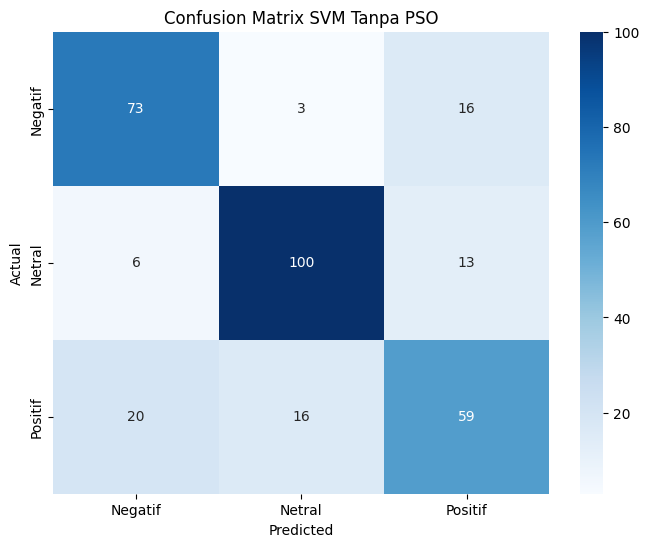

In [12]:
cnf_matrix_linear = confusion_matrix(y_test,y_pred_linear,labels=[0,1,2])

# Membuat visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_linear, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif' ,'Netral','Positif'], yticklabels=['Negatif','Netral','Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVM Tanpa PSO')
plt.show()

## SVM PSO

In [10]:
def objective_function(params, kernel, X_train, y_train, X_test, y_test):
    C, gamma = params 
    model = svm.SVC(kernel=kernel, C=C, gamma=gamma) 
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return -accuracy_score(y_test, predictions)  # Mengembalikan nilai negatif untuk memaksimalkan

In [11]:
# Kelas untuk Partikel
class Particle:
    def __init__(self, bounds, kernel, X_train, y_train, X_test, y_test):
        self.position = np.random.uniform(bounds[0], bounds[1], size=len(bounds[0]))
        self.velocity = np.random.uniform(-1, 1, size=len(bounds[0]))
        self.best_position = np.copy(self.position)
        self.best_value = objective_function(self.position, kernel, X_train, y_train, X_test, y_test)

    def update_velocity(self, global_best_position, inertia_weight=0.6, cognitive_weight=1.6, social_weight=1.0):
        r1 = np.random.rand(len(self.position))
        r2 = np.random.rand(len(self.position))
        cognitive_component = cognitive_weight * r1 * (self.best_position - self.position)
        social_component = social_weight * r2 * (global_best_position - self.position)
        self.velocity = inertia_weight * self.velocity + cognitive_component + social_component

    def update_position(self, bounds, kernel, X_train, y_train, X_test, y_test):
        self.position += self.velocity
        # Pastikan posisi tetap dalam batas
        self.position = np.clip(self.position, bounds[0], bounds[1])
        current_value = objective_function(self.position, kernel, X_train, y_train, X_test, y_test)
        if current_value < self.best_value:
            self.best_value = current_value
            self.best_position = np.copy(self.position)
            # Fungsi utama PSO
def pso(num_particles, bounds, max_iter, kernel, X_train, y_train, X_test, y_test):
    particles = [Particle(bounds, kernel, X_train, y_train, X_test, y_test) for _ in range(num_particles)]
    global_best_position = particles[0].best_position
    global_best_value = particles[0].best_value

    for _ in range(max_iter):
        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.update_position(bounds, kernel, X_train, y_train, X_test, y_test)
    
            if particle.best_value < global_best_value:
                global_best_value = particle.best_value
                global_best_position = particle.best_position

    return global_best_position, global_best_value

In [119]:
bounds = (np.array([0.1, 0.001]), np.array([100, 1]))  # Batas untuk C, gamma
kernel_choice_r = 'rbf'  # Pilih kernel yang diinginkan
best_params_r, best_score_r = pso(num_particles=50, bounds=bounds, max_iter=50, kernel=kernel_choice_r, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print("Best Parameters RBF: C={}, gamma={}".format(best_params_r[0], best_params_r[1]))

Best Parameters RBF: C=10.455674691618418, gamma=0.309447969877839


In [43]:
best_C_r = best_params_r[0]
best_gamma_r = best_params_r[1]

In [16]:
# Melatih model akhir dengan parameter terbaik
final_model_rbf = train_svm_model(X_train, y_train, kernel='rbf', C=10.45, gamma=0.309)

Jml. Fitur	: 5932


In [17]:
# Evaluasi model akhir
evaluate_model(final_model_rbf, X_test, y_test)
y_pred_rbf = final_model_rbf.predict(X_test)

              precision    recall  f1-score   support

           0       0.74      0.82      0.77        92
           1       0.86      0.87      0.86       119
           2       0.74      0.65      0.69        95

    accuracy                           0.78       306
   macro avg       0.78      0.78      0.78       306
weighted avg       0.78      0.78      0.78       306

Precision	: 0.784
Recall		: 0.7843
Accuracy	: 0.7843
F1-Score	: 0.7827


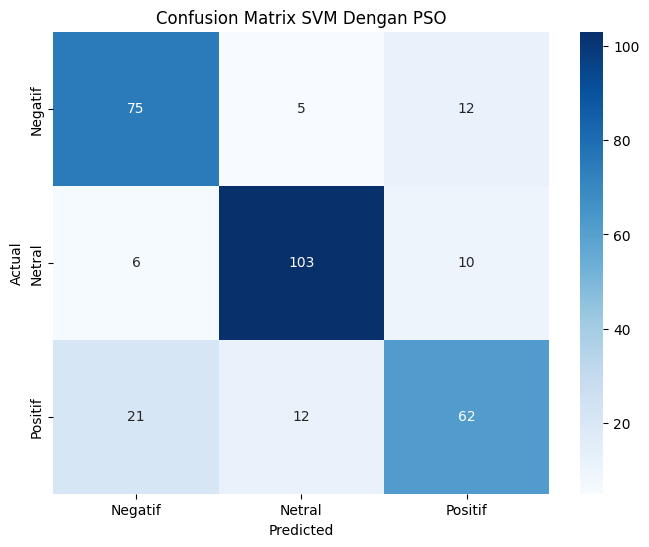

In [18]:
cnf_matrix_rbf_pso = confusion_matrix(y_test,y_pred_rbf,labels=[0,1,2])

# Membuat visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_rbf_pso, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif' ,'Netral','Positif'], yticklabels=['Negatif','Netral','Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVM Dengan PSO')
plt.show()

In [33]:
import pickle
# Simpan Model
### KODE PROGRAM
filename = f'model-svm-pso.pickle'
pickle.dump(final_model_rbf, open(filename, 'wb'))
vectorizer.stop_words_ = None
clf = final_model_rbf
with open(filename, 'wb') as fout:
    pickle.dump((vectorizer,clf), fout)
print(f'Nama Model\t: {filename}')

Nama Model	: model-svm-pso.pickle


# Prediksi

In [34]:
filename = 'model-svm-pso.pickle'
fs_label = filename[10:13];
text = ['kenapa tiktok shop harus ditutup padahal bagus kalau ada tiktok shop ']
with open(filename, 'rb') as fin:
    vectorizer, clf = pickle.load(fin)
    tfidf_text_vectors = vectorizer.transform(text)
    y_pred = clf.predict(tfidf_text_vectors)
y_pred = clf.predict(tfidf_text_vectors)
print(y_pred)
if y_pred==1:
    sentimen_svm = 'Ulasan netral'
elif y_pred == 0:
    sentimen_svm = 'Ulasan negatif'
elif y_pred ==2:
    sentimen_svm = 'Ulasan positif'
print('Teks\t\t: ', text[0])
print('Sentimen\t: ', sentimen_svm) 

[2]
Teks		:  kenapa tiktok shop harus ditutup padahal bagus kalau ada tiktok shop 
Sentimen	:  Ulasan positif


In [24]:
# Load data dari CSV
df_sample = pd.read_csv('sample_data_prediksi.csv')
df_sample.head(10)

,text,label
0,Tiktokshop mbalik tapi harga2nya masih lebih m...,1
1,"@tanyakanrl Gaakan bisalah wkw, tiktokshop di ...",2
2,"tiktokshop ditutup jir, baru ngeh fiturnya dah...",2
3,@Prynkaslma Wkwkkw gara2 tiktok shop tutup buk...,0
4,sebenernya tiktokshop tuh ditutup gara gara yg...,0
5,ngakak bgt mama marah marah karna tiktok shop ...,0
6,Lucu ini si tiktok akusisi tokopedia buka tikt...,2
7,Tokped shopee dan e commerce yang lain ibarat ...,0
8,"@Depa_29 @tanyakanrl Bukan soal drama nya, pas...",0
9,Bisa di bilang cukup sedih TikTok-shop mau di ...,0


## Preprocessing data prediksi

In [32]:
import pickle

In [71]:
df_sample = pd.read_csv('data_prediksi_2.csv')

In [43]:
def preprocess_text(text):
    # Case folding
    text = text.lower()

    # Filtering
    #menghapus username twitter
    text = re.sub('@[^\s]+','',text)
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # Memperbaiki pemisahan kata yang salah menggunakan regex
    text = re.sub(r'([a-zA-Z])\-([a-zA-Z])', r'\1 \2', text)
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    #remove punctuation
    text = re.sub(r'[{}]+'.format(re.escape(string.punctuation)), ' ', text)
    # remove white space
    text = text.strip()
    # Remove numbers
    text = re.sub(r'\d+', '', text)  # Menghapus semua angka
    #remove multiple white space
    text = re.sub('\s+',' ',text)
    # Mengganti "tiktokshop" menjadi "tiktok shop"
    text = re.sub(r'tiktokshop', 'tiktok shop', text, flags=re.IGNORECASE)
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    # Tokenizing
    words = word_tokenize(text)

    # Load slang words
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b(' + '|'.join(kamusSlang.keys()) + r')\b')
    content = []
    for kata in words:
        filterSlang = pattern.sub(lambda x: kamusSlang[x.group()], kata)
        content.append(filterSlang.lower())
    
    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_text = [stemmer.stem(word) for word in content]

    # Mengembalikan teks yang telah diproses
    return " ".join(stemmed_text)

In [72]:
X_test_sample = df_sample['text']
# Terapkan preprocessing pada 20 data uji
preprocessed_samples = X_test_sample.apply(preprocess_text)

# Menampilkan hasil
print(preprocessed_samples)

0     tiktok shop mbalik tapi harga masih lebih maha...
1     gaakan bisa wkw tiktok shop di larang juga buk...
2     tiktok shop tutup anjing baru sadar fiturnya d...
3               tertawa karena tiktok shop tutup bukann
4     benar tiktok shop tuh tutup karena karena yang...
5     tertawa sangat mama marah marah karena tiktok ...
6     lucu ini si tiktok akusisi tokopedia buka tikt...
7     tokopedia shopee dan e commerce yang lain ibar...
8     bukan soal drama nya pasti ada sedih dari tikt...
9     bisa di bilang cukup sedih tiktok shop mau di ...
10               tiktok shop ini ga sehat sangat anjing
11    wkwkw temporary closed kemarin kak soal tiktok...
12                  habis bantu live tiktok shop sayang
13    nowadays imma sucker for tiktok live shop rasa...
14        tiktok shop memang ga ada gratis ongkos kirim
15    habis join live shop di tiktok terus tbtb sell...
16         tidak ada opsi lain selain tutup tiktok shop
17    lah anjing saya kira tiktok shop doang yan

In [73]:
text_samples = preprocessed_samples.tolist()  # Mengambil kolom 'text' sebagai list

# Load model
filename = 'model-svm-pso.pickle'
with open(filename, 'rb') as fin:
    vectorizer, clf = pickle.load(fin)

# Transformasi data menggunakan vectorizer
tfidf_text_vectors = vectorizer.transform(text_samples).toarray()  # Menggunakan text_samples

# Melakukan prediksi
y_pred = clf.predict(tfidf_text_vectors)

# Menampilkan hasil prediksi
for i, text in enumerate(text_samples):  # Menggunakan text_samples
    if y_pred[i] == 1:
        sentimen_svm = 'Ulasan netral'
    elif y_pred[i] == 0:
        sentimen_svm = 'Ulasan negatif'
    elif y_pred[i] == 2:
        sentimen_svm = 'Ulasan positif'
    print('Data ',i+1)
    print('Teks\t\t: ', text)
    print('Sentimen\t: ', sentimen_svm)

Data  1
Teks		:  tiktok shop mbalik tapi harga masih lebih mahal banding app belah seperti shopee dan lazada ga bisa buat kulak jual lagi
Sentimen	:  Ulasan netral
Data  2
Teks		:  gaakan bisa wkw tiktok shop di larang juga bukan karena minta dagang sana sih tapi gede rasa gede rasa regulasi jangan kegeeran kawan
Sentimen	:  Ulasan positif
Data  3
Teks		:  tiktok shop tutup anjing baru sadar fiturnya deh tidak ada uang
Sentimen	:  Ulasan positif
Data  4
Teks		:  tertawa karena tiktok shop tutup bukann
Sentimen	:  Ulasan negatif
Data  5
Teks		:  benar tiktok shop tuh tutup karena karena yang dagang tanah abang atau titip saing deh
Sentimen	:  Ulasan negatif
Data  6
Teks		:  tertawa sangat mama marah marah karena tiktok shop buka lagi kata bisa bisa aku check out melulu
Sentimen	:  Ulasan negatif
Data  7
Teks		:  lucu ini si tiktok akusisi tokopedia buka tiktok shop lagi lah isi sama seperti dulu belum tutup tidak ada isi tokpednya cm tulis doang wkwkwk memang paling enak ngibulin perint